# Code to visualise short time scale variations

In [1]:
%matplotlib qt
#notebook backend important
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import cv2
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import askopenfilenames
import matplotlib.animation as animation
from scipy import signal 

In [2]:

def index_find(depths,click):
    lst = depths>click
    for i,v in enumerate(lst):
        if v==True:
            return i

In [3]:
excel_path = askopenfilename() #paTh to excel doc with data
data = pd.read_excel(excel_path)

In [4]:
%matplotlib qt

run_num = int(input('Run number:'))
print('Data read')
#getting data from excel doc
rho_bottom = data.iloc[run_num-1, 7]
rho_top = data.iloc[run_num-1, 6]
depth = data.iloc[run_num-1, 2]
tank_length=1.2

Run number:1
Data read


In [7]:
#now choose background image

background_path = askopenfilename() 
b_image = cv2.imread(background_path,0)

In [8]:
#Choose area that you want to average over
plt.figure()
plt.title('Choose Area to Average over')
plt.ylabel('z (m)')
plt.imshow(b_image, cmap='gist_gray')
print('Top left then bottom right' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_0=int(np.round(density_locations[0][1]))
ztop_0=int(np.round(density_locations[1][1]))
xleft=int(np.round(density_locations[0][0]))
xright=int(np.round(density_locations[1][0]))

back_crop= b_image[zbot_0:ztop_0,xleft:xright]


Top left then bottom right
Locations recorded


In [9]:
log_back = np.log(back_crop)

#getting rid of unwated inf_values
log_back[np.isinf(log_back)]=np.nan

mean_ratio_profile = np.mean(log_back,1)
intensity = mean_ratio_profile[::-1]
depth_array = np.linspace(0,depth,len(mean_ratio_profile))

In [10]:
splintensity=np.copy(intensity)

plt.figure()
plt.plot(intensity,depth_array)
plt.xlabel('ln (Ix/Ix0)')
plt.ylabel('z (m)')
plt.title('Select Top Section of Absorption Profile')
print('Choose bottom of top section')
topsection = plt.ginput(1)[0][1]
print('Location recorded')
ztop=index_find(depth_array,topsection) 
splintensity[ztop:]=splintensity[ztop]

Choose bottom of top section
Location recorded


In [11]:
plt.figure()
plt.plot(splintensity,depth_array)
plt.xlabel('ln (Ix/Ix0)')
plt.ylabel('z (m)')
plt.title('Select Bottom Section of Absorption Profile')
print('Choose top then bottom')
bottomsection = plt.ginput(2)
print('Locations recorded')

Choose top then bottom
Locations recorded


In [12]:
slope = (bottomsection[0][0]-bottomsection[1][0])/bottomsection[0][1]
intercept = bottomsection[0][1]-bottomsection[0][0]/slope
zbot=index_find(depth_array, bottomsection[0][1]) 
splintensity[0:zbot]=slope*(np.linspace(0,bottomsection[0][1], zbot)-intercept)
plt.figure()
plt.title('Absorbtion Profile')
plt.xlabel('ln (Ix/Ix0)')
plt.ylabel('z (m)')
plt.plot(intensity,depth_array, 'b', label='Raw')
plt.plot(splintensity,depth_array, 'r',label='Updated')
plt.legend()

In [14]:
#determining the location of density samples (rho_bottom, rho_top)

plt.figure()
plt.title('Density Sample Locations')
plt.ylabel('z (m)')
plt.imshow(back_crop, cmap='gist_gray')
print('Position of density sample close to bottom, then close to free surface' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_rho=int(np.round(density_locations[0][1]))
ztop_rho=int(np.round(density_locations[1][1]))

beta = (rho_bottom-rho_top)/(splintensity[zbot_rho]-splintensity[ztop_rho])
splintensity_bottom_ref = splintensity[zbot_rho]

rho = rho_bottom+np.float64(beta*(splintensity-splintensity_bottom_ref))

Position of density sample close to bottom, then close to free surface
Locations recorded


In [15]:
plt.figure()
plt.plot(rho, depth_array)
plt.xlabel('rho (kg/m^3)')
plt.ylabel('z (m)')
plt.title('Background Density')

Text(0.5, 1.0, 'Background Density')

In [19]:
#now choose the pictures you want to look over
foreground_path = askopenfilenames()
no_images = len(foreground_path)
os.mkdir('{}/densityfields'.format(os.path.dirname(foreground_path[0])))

In [20]:
%matplotlib inline
print('{} Images to analyse!'.format(no_images))
#done to stop hundreds of plots occuring

198 Images to analyse!


In [ ]:
ims=[]

fig = plt.figure(figsize=(15,8))
cmap = matplotlib.cm.coolwarm
cmap.set_under(color='black')
    
for i in range(no_images):
    f_image = cv2.imread(foreground_path[i],0)
    f_image_crop=f_image[zbot_0:ztop_0,:]
    log = np.log(f_image_crop)

    #getting rid of unwated inf_values
    log[np.isinf(log)]=np.nan
    
    density = rho_bottom+np.float64(beta*(log-splintensity_bottom_ref))
    delta_den=density[:,50:-50][::-1]-rho[:,None]
    density_filt=signal.medfilt2d(delta_den,3)
    a=density_filt
    a[a>3]=np.nan
    
 
    plt.clf
    plt.xlabel('Length (m)')
    plt.ylabel('Depth (m)')
    plt.title('Run {}'.format(run_num), fontsize=20)
    
    im=plt.imshow(a[50:,:][::-1], cmap=cmap, animated=True, vmin=-2,vmax=2, extent=[0,tank_length,depth,0])
    plt.colorbar()
    ims.append([im])
    plt.close("all")
    if i in [100,200,300,400,500,600,700,800,900]:
        print('{} Images out of {} Done!'.format(i,no_images))
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)

ani.save('{}/densityfields/run_{}.mp4'.format(os.path.dirname(foreground_path[0]),run_num))


C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\u6201343\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


100 Images out of 198 Done!


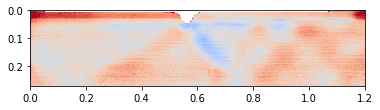

In [47]:
plt.imshow(a[50:,:][::-1], cmap=cmap, animated=True, vmin=-2,vmax=2, extent=[0,tank_length,depth,0])